In [ ]:
# It is still in proccess currently i am unable to get the output there are may be some errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

2024-06-28 12:00:32.857458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 12:00:32.857578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 12:00:33.015137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory('/kaggle/input/preprocessed-1/tusimple_preprocessed/training',shuffle=False,batch_size=64,class_mode='binary',target_size=(256, 320))
num = images_set.samples

Found 7252 images belonging to 2 classes.


In [3]:
num_batches = (num // 64) + 1

X = []
Y = []

for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0]
    batch_labels = batch[1]

    for index, label in enumerate(batch_labels):
        if label == 0: 
            X.append(batch_images[index])
        else:
            Y.append(np.mean(batch_images[index], axis=2))
    print(f'Processing batch {i + 1}')

X = np.array(X)
Y = np.array(Y)

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing batch 50
Processin

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [6]:
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)
X = np.array(X[:3000])
Y = np.array(Y[:3000])
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [7]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet_softmax(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet_softmax()

In [8]:
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 320,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 320,  │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 320,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 160,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 160,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 160,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 80,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 80,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 80,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 40,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 40,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 40,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 20,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 20,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 20,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 20,    │          0 │ conv2d_9[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 1
batch_size = 8
history = model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_val, Y_val),batch_size=batch_size)

2024-06-28 12:06:11.132595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.80016, expected 4.21859
2024-06-28 12:06:11.132652: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.08907, expected 3.5075
2024-06-28 12:06:11.132661: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.73288, expected 3.15131
2024-06-28 12:06:11.132669: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.00648, expected 3.42491
2024-06-28 12:06:11.132676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.35322, expected 3.77165
2024-06-28 12:06:11.132684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.5467, expected 3.96513
2024-06-28 12:06:11.132692: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.44602, expected 3.86445
2024-06-28 12:06:11.132699: E external/local_xla/xla/

337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8879 - loss: 31293205118976.0000

2024-06-28 12:08:39.888094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 319: 1.96671, expected 1.60692
2024-06-28 12:08:39.888492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61759: 2.46581, expected 2.10602
2024-06-28 12:08:39.888649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81919: 2.37851, expected 2.01872
2024-06-28 12:08:39.889112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 163840: 5.52411, expected 4.56425
2024-06-28 12:08:39.889138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 163841: 6.77772, expected 5.81786
2024-06-28 12:08:39.889146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 163842: 6.22251, expected 5.26265
2024-06-28 12:08:39.889154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 163843: 5.38916, expected 4.4293
2024-06-28 12:08:39.889162

338/338 ━━━━━━━━━━━━━━━━━━━━ 195s 408ms/step - accuracy: 0.8880 - loss: 34876380151808.0000 - val_accuracy: 0.9573 - val_loss: 6967955225051136.0000


In [11]:
preds = model.predict(X_val)

2024-06-28 12:09:25.645355: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,320]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-28 12:09:25.828705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81927: 3.08912, expected 2.67753
2024-06-28 12:09:25.828759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81928: 2.68598, expected 2.27438
2024-06-28 12:09:25.828775: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81929: 2.80074, expected 2.38914
2024-06-28 12:09:25.828793: E external/local_xla/xla/service/gpu/buffer_comparato

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step

2024-06-28 12:10:32.910741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.35905, expected 2.92212
2024-06-28 12:10:32.910798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 2.40533, expected 1.9684
2024-06-28 12:10:32.910807: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 73: 3.24955, expected 2.81262
2024-06-28 12:10:32.910815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 82: 3.24193, expected 2.80499
2024-06-28 12:10:32.910823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 86: 2.5469, expected 2.10997
2024-06-28 12:10:32.910831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 107: 3.19132, expected 2.75439
2024-06-28 12:10:32.910838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 133: 3.25122, expected 2.81429
2024-06-28 12:10:32.910846: E external/local_xla/x

10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step 


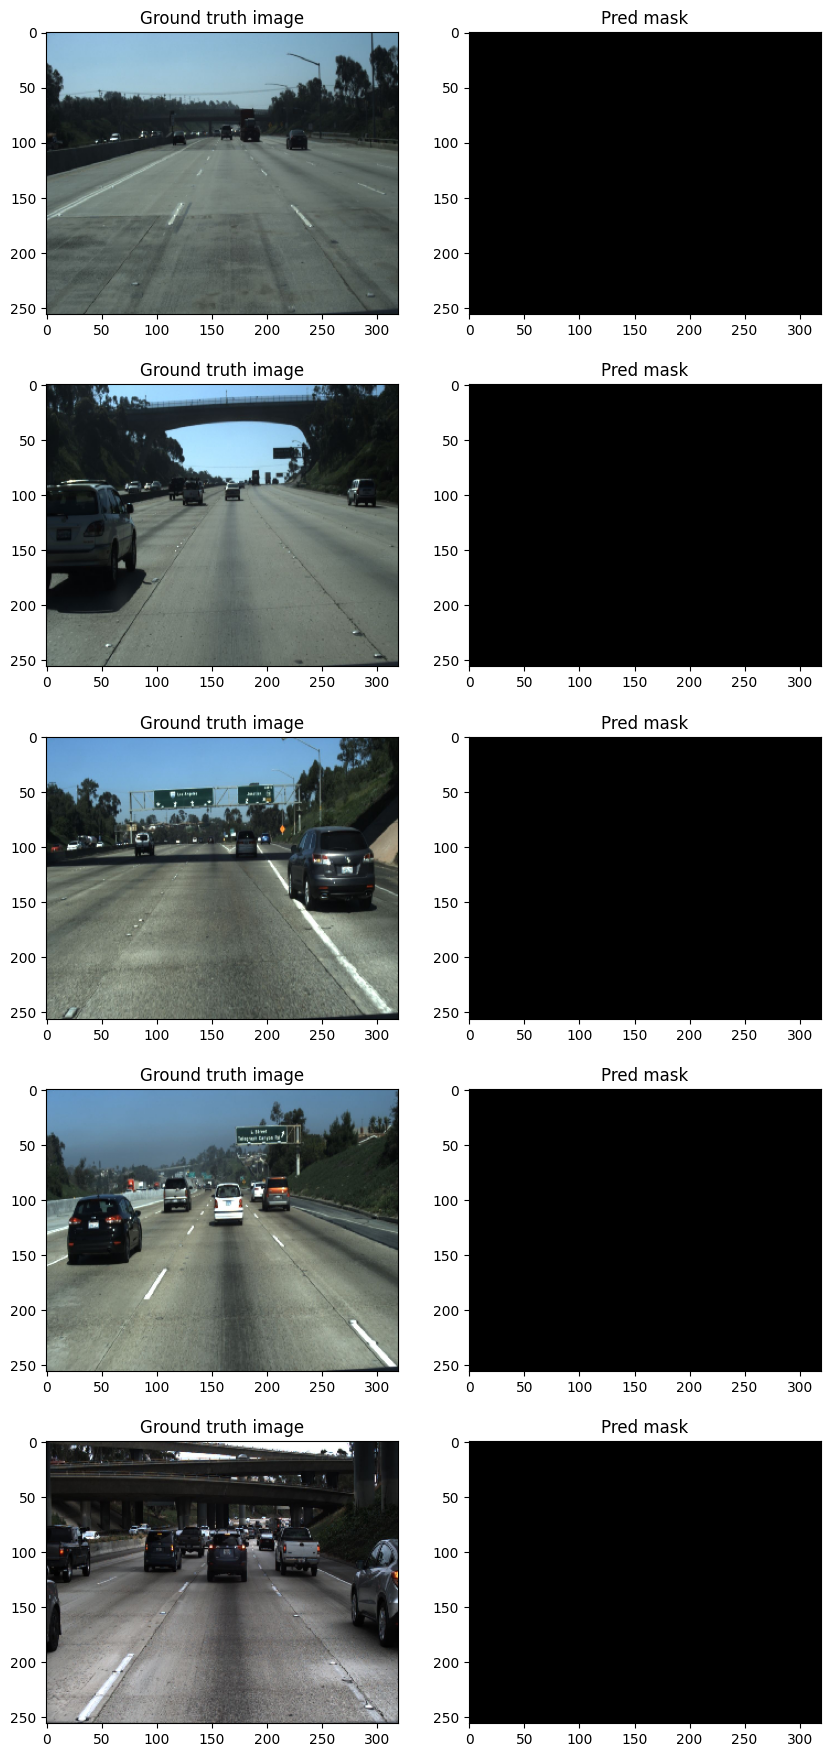

In [14]:
import cv2
plt.figure(figsize=(10, 45))
s, e = 0, 5
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [15]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
print(accuracy_value)

0.95727783


In [16]:
model.save('lane_detection_model.h5')

In [17]:
import shutil
shutil.make_archive('lane_detection_model', 'zip', 'lane_detection_model.h5')

'/kaggle/working/lane_detection_model.zip'

In [18]:
from IPython.display import FileLink
FileLink(r'lane_detection_model.zip')

/kaggle/working/lane_detection_model.zip

In [19]:
from sklearn import svm
import joblib
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model
import keras

def unet_feature_extractor(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


unet_model = unet_softmax()
unet_model.load_weights('lane_detection_model.h5')

feature_extractor_model = Model(inputs=unet_model.input, outputs=unet_model.layers[-2].output)

In [ ]:
batch_size = 32
num_samples = len(X_train)
predictions = []

for i in range(0, num_samples, batch_size):
    batch_features = feature_extractor_model.predict(X_train[i:i+batch_size])
    predictions.append(batch_features)

features = np.concatenate(predictions, axis=0)
features_flat = features.reshape(-1, features.shape[-1])

In [ ]:
import gc

keras.backend.clear_session()

gc.collect()

In [ ]:
with tf.device('/CPU:0'):
    features = feature_extractor_model.predict(X_train)
    features_flat = features.reshape(-1, features.shape[-1])

In [20]:
import numpy as np
from sklearn import svm

features = feature_extractor_model.predict(X_train)
features_flat = features.reshape(-1, features.shape[-1])
labels_flat = Y_train.flatten()

svm_model = svm.SVC()
svm_model.fit(features_flat, labels_flat)

joblib.dump(svm_model, 'svm_lane_detection_model.pkl')

13/85 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/532049196.py", line 4, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

Out of memory while trying to allocate 3277458064 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  148.38MiB
              constant allocation:         4B
        maybe_live_out allocation:  640.00MiB
     preallocated temp allocation:    3.05GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    3.82GiB
              total fragmentation:     2.6KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.11GiB
		Operator: op_type="Conv2D" op_name="functional_5_1/conv2d_40_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: u8[2269642752]
		==========================

	Buffer 2:
		Size: 640.00MiB
		Operator: op_type="Conv2D" op_name="functional_5_1/conv2d_24_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,64,256,320]
		==========================

	Buffer 3:
		Size: 640.00MiB
		Operator: op_type="AddV2" op_name="functional_5_1/conv2d_44_1/add" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[32,256,320,64]
		==========================

	Buffer 4:
		Size: 320.00MiB
		Operator: op_type="Conv2D" op_name="functional_5_1/conv2d_40_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[32,128,128,160]
		==========================

	Buffer 5:
		Size: 36.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,1024,1024]
		==========================

	Buffer 6:
		Size: 30.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[32,256,320,3]
		==========================

	Buffer 7:
		Size: 18.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,1024,512]
		==========================

	Buffer 8:
		Size: 18.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,1024]
		==========================

	Buffer 9:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 10:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 11:
		Size: 8.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[2,2,1024,512]
		==========================

	Buffer 12:
		Size: 4.50MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,256]
		==========================

	Buffer 13:
		Size: 4.50MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,512]
		==========================

	Buffer 14:
		Size: 2.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,256]
		==========================

	Buffer 15:
		Size: 2.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,256]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_17174]

In [ ]:
svm_model = joblib.load('svm_lane_detection_model.pkl')

input_image = np.random.rand(1, 256, 320, 3)

features = feature_extractor_model.predict(input_image)
features_flat = features.reshape(-1, features.shape[-1])

predictions = svm_model.predict(features_flat)

segmentation_result = predictions.reshape(input_image.shape[1], input_image.shape[2])

plt.imshow(segmentation_result, cmap='gray')
plt.title('Segmentation Result')
plt.show()
